# Character level language model - Dinosaurus land
任务：  
通过创建一个字符级语言模型来生成新的名称。
通过这次的任务，可以学习：
* 如何存储文本数据以便使用RNN进行处理
* 如何通过在每个时间步骤采样预测并将其传递到下一个RNN单元来合成数据
* 如何构建一个字符级文本生成递归神经网络
* 为什么修剪梯度很重要


In [1]:
import numpy as np
from dinos_utils import *
import random

### 1.1- 数据预处理
读取数据集内恐龙名字，创建一个字符表

In [2]:
data = open('dinos.txt','r').read()
data = data.lower()
chars = list(set(data))
print(sorted(chars))
data_size, vocab_size = len(data),len(chars)
print('There are %d total characters and %d unique characters in your data.' % (data_size, vocab_size))

['\n', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
There are 18766 total characters and 27 unique characters in your data.


  chars包含a-z（26个字符）以及将“\ n”（或换行符），在这里 它表示恐龙名称的结束而不是句子的结尾。 在下面的单元格中，我们创建一个python字典（即哈希表），将每个字符映射到0-26的索引。   
  我们还创建了另一个python字典，它将每个索引映射回相应的字符。 这将帮助您确定哪个索引对应于softmax图层的概率分布输出中的哪个字符。char_to_ix和ix_to_char是python词典。

In [3]:
char_to_index = {ch:i for i,ch in enumerate(sorted(chars))}
index_to_char = {i:ch for i,ch in enumerate(sorted(chars))}
print(index_to_char)

{0: '\n', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


### 1.2 模型
* 初始化参数
* 优化  
    * 前向传播计算损失函数  
    * 反向传播计算相应梯度  
    * 修剪梯度避免梯度爆炸  
    * 利用梯度更新参数  
* 返回参数  
这里选用的模型就是基础的RNN模型，每一步输出都会给出下一个预测的字符。
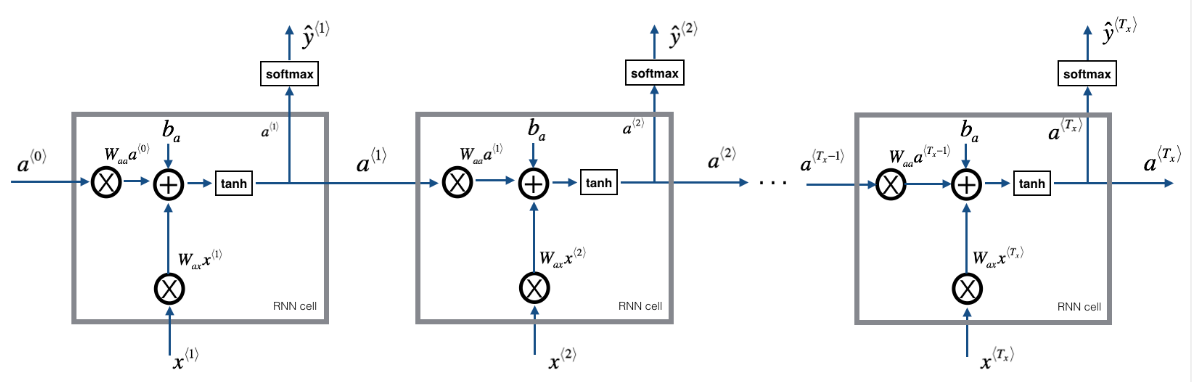

### 2-搭建模型
在这一部分需要搭建两个模块：
* gradient clipping（避免梯度爆炸） 
* sampling （生成字符）


#### 2.1 优化过程内添加clipping

梯度剪裁的方法有很多种; 这里将使用一个简单的逐元素剪切过程，其中梯度向量的每个元素被剪切为位于某个范围[-N，N]之间。 更一般地说，您将提供maxValue（比如10）。 在此示例中，如果梯度向量的任何分量大于10，则将其设置为10; 如果梯度向量的任何分量小于-10，则将其设置为-10。 如果介于-10和10之间，则不管它。  

In [4]:
### GRADED FUNCTION: clip

def clip(gradients, maxValue):
    '''
    Clips the gradients' values between minimum and maximum.
    
    Arguments:
    gradients -- a dictionary containing the gradients "dWaa", "dWax", "dWya", "db", "dby"
    maxValue -- everything above this number is set to this number, and everything less than -maxValue is set to -maxValue
    
    Returns: 
    gradients -- a dictionary with the clipped gradients.
    '''
    dWaa, dWax, dWya, db, dby = gradients['dWaa'], gradients['dWax'], gradients['dWya'], gradients['db'], gradients['dby']
    for gradient in [dWaa, dWax, dWya, db, dby]:
        np.clip(gradient, -maxValue, maxValue,out = gradient)
    gradients = {"dWaa": dWaa, "dWax": dWax, "dWya": dWya, "db": db, "dby": dby}
    
    return gradients


In [5]:
np.random.seed(3)
dWax = np.random.randn(5,3)*10
dWaa = np.random.randn(5,5)*10
dWya = np.random.randn(2,5)*10
db = np.random.randn(5,1)*10
dby = np.random.randn(2,1)*10
gradients = {"dWax": dWax, "dWaa": dWaa, "dWya": dWya, "db": db, "dby": dby}
gradients = clip(gradients, 10)
print("gradients[\"dWaa\"][1][2] =", gradients["dWaa"][1][2])
print("gradients[\"dWax\"][3][1] =", gradients["dWax"][3][1])
print("gradients[\"dWya\"][1][2] =", gradients["dWya"][1][2])
print("gradients[\"db\"][4] =", gradients["db"][4])
print("gradients[\"dby\"][1] =", gradients["dby"][1])

gradients["dWaa"][1][2] = 10.0
gradients["dWax"][3][1] = -10.0
gradients["dWya"][1][2] = 0.2971381536101662
gradients["db"][4] = [10.]
gradients["dby"][1] = [8.45833407]


### 2.2 采样
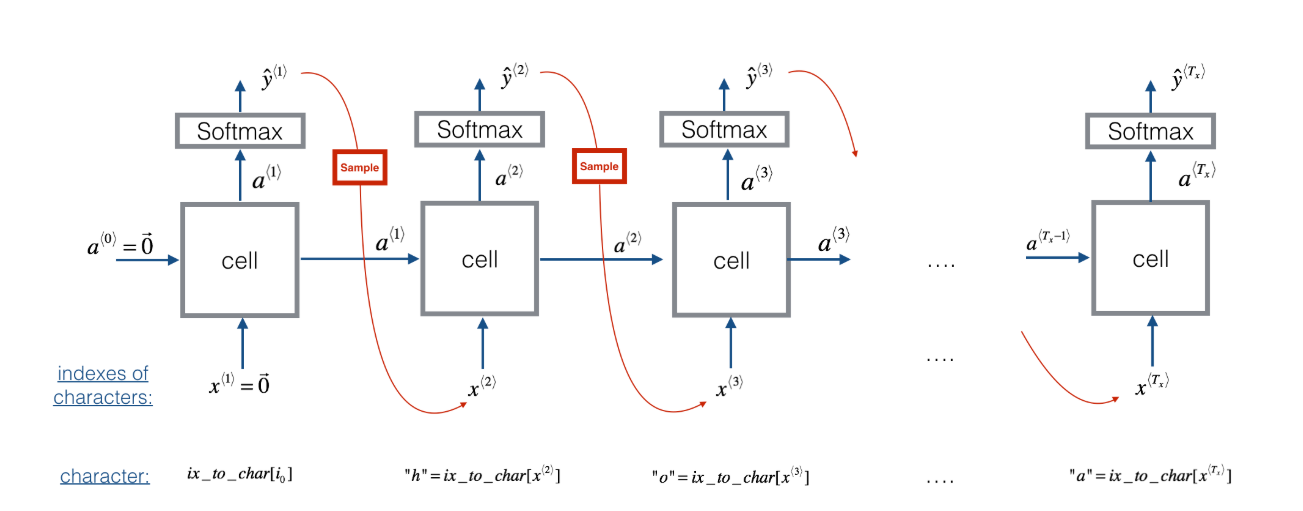
利用sample函数实现采样过程，包含以下四步：  
1.默认输入$x^{\langle 1 \rangle} = \vec{0}$以及 $a^{\langle 0 \rangle} = \vec{0}$  
2.做前向传播：$$ a^{\langle t+1 \rangle} = \tanh(W_{ax}  x^{\langle t \rangle } + W_{aa} a^{\langle t \rangle } + b)\tag{1}$$$$ z^{\langle t + 1 \rangle } = W_{ya}  a^{\langle t + 1 \rangle } + b_y \tag{2}$$$$ \hat{y}^{\langle t+1 \rangle } = softmax(z^{\langle t + 1 \rangle })\tag{3}$$ 
3.进行抽样：根据$\hat {y} ^ {\langle t + 1 \rangle}$指定的概率分布选择下一个索引。 这意味着如果$ \hat {y} ^ {\langle t + 1 \rangle} _i = 0.16 $，则将以16％的概率选择索引“i”。 要实现它，可以使用np.random.choice；

np.random.seed(0)  
p = np.array([0.1, 0.0, 0.7, 0.2])  
index = np.random.choice([0, 1, 2, 3], p = p.ravel())


4.利用sample()来覆盖x.目前存储$ x ^ {\langle t \rangle} $，值为$ x ^ {\langle t + 1 \rangle} $。 将通过创建与选择字符相对应的one-hot来表示$ x ^ {\langle t + 1 \rangle} $。 然后，将在步骤1中向前传播$ x ^ {\langle t + 1 \rangle} $并继续重复该过程，直到得到一个“\ n”字符，表示已到达恐龙名称的末尾。


np.random.choice的使用方法：    
* 参数意思分别 是从a 中以概率P，随机选择3个, p没有指定的时候相当于是一致的分布  
a1 = np.random.choice(a=5, size=3, replace=False, p=None)  
print(a1)  
* 非一致的分布，会以多少的概率提出来
a2 = np.random.choice(a=5, size=3, replace=False, p=[0.2, 0.1, 0.3, 0.4, 0.0])
print(a2)   
* replace 代表的意思是抽样之后还放不放回去，如果是False的话，那么出来的三个数都不一样，如果是True的话， 有可能会出现重复的，因为前面的抽的放回去了。  

np.ravel() 将多维数组降为一维 

np.ravel()和np.flatten()区别：  
* np.ravel()返回的是视图，修改时会影响原始矩阵 
* np.flatten()返回一份拷贝，对拷贝所做修改不会影响原始矩阵  


In [6]:
# GRADED FUNCTION: sample

def sample(parameters, char_to_ix, seed):
    """
    根据RNN输出的概率分布序列对字符序列进行采样
    
    Arguments:
    parameters -- python dictionary containing the parameters Waa, Wax, Wya, by, and b. 
    char_to_ix -- python dictionary mapping each character to an index.
    seed -- used for grading purposes. Do not worry about it.

    Returns:
    indices -- a list of length n containing the indices of the sampled characters.
    """
    Waa, Wax, Wya, by, b = parameters['Waa'], parameters['Wax'], parameters['Wya'], parameters['by'], parameters['b']
    vocab_size = by.shape[0]
    n_a = Waa.shape[1]
    
    # Step 1: Create the one-hot vector x for the first character (initializing the sequence generation). (≈1 line)
    x = np.zeros((vocab_size,1))
    a_prev = np.zeros((n_a,1))
    # Create an empty list of indices, this is the list which will contain the list of indices of the characters to generate (≈1 line)
    indices=[]
    # Idx是检测换行符的标志，我们将其初始化为-1
    idx=-1
    # 做t步循环。在每一步计算输出字符的概率，并且将其索引添加到indices，如果达到字符个数上限（50个），将停止循环。
    counter = 0
    newline_character = char_to_index['\n']
    
    while(idx !=newline_character and counter!=50):
        # Step 2: Forward propagate x using the equations (1), (2) and (3)
        a = np.tanh(np.dot(Wax,x)+np.dot(Waa,a_prev)+b)
        z = np.dot(Wya,a)+by
        y = softmax(z)
        
        # for grading purposes
        np.random.seed(counter+seed) 
        
        # Step 3: Sample the index of a character within the vocabulary from the probability distribution y
        idx = np.random.choice(list(range(vocab_size)),p = y.ravel())
        indices.append(idx)
        
        # Step 4: Overwrite the input character as the one corresponding to the sampled index.
        x = np.zeros((vocab_size,1))
        x[idx] = 1
        
        a_prev = a
        seed += 1
        counter += 1
        
    if (counter==50):
        indices.append(char_to_index['\n'])
        
    return indices        

In [7]:
np.random.seed(2)
_, n_a = 20, 100
Wax, Waa, Wya = np.random.randn(n_a, vocab_size), np.random.randn(n_a, n_a), np.random.randn(vocab_size, n_a)
b, by = np.random.randn(n_a, 1), np.random.randn(vocab_size, 1)
parameters = {"Wax": Wax, "Waa": Waa, "Wya": Wya, "b": b, "by": by}


indices = sample(parameters, char_to_index, 0)
print("Sampling:")
print("list of sampled indices:", indices, '\n')
print("list of sampled characters:", [index_to_char[i] for i in indices])

Sampling:
list of sampled indices: [12, 17, 24, 14, 13, 9, 10, 22, 24, 6, 13, 11, 12, 6, 21, 15, 21, 14, 3, 2, 1, 21, 18, 24, 7, 25, 6, 25, 18, 10, 16, 2, 3, 8, 15, 12, 11, 7, 1, 12, 10, 2, 7, 7, 11, 17, 24, 12, 12, 0, 0] 

list of sampled characters: ['l', 'q', 'x', 'n', 'm', 'i', 'j', 'v', 'x', 'f', 'm', 'k', 'l', 'f', 'u', 'o', 'u', 'n', 'c', 'b', 'a', 'u', 'r', 'x', 'g', 'y', 'f', 'y', 'r', 'j', 'p', 'b', 'c', 'h', 'o', 'l', 'k', 'g', 'a', 'l', 'j', 'b', 'g', 'g', 'k', 'q', 'x', 'l', 'l', '\n', '\n']


### 3 - 建立语言模型
建立字符集的语言模型去生成文本。  
* 3.1 梯度下降
实现随机梯度下降，每次从训练集中读取一个样本。  


In [8]:
# GRADED FUNCTION: optimize

def optimize(X, Y, a_prev, parameters, learning_rate = 0.01):
    """
    Execute one step of the optimization to train the model.
    
    Arguments:
    X -- list of integers, where each integer is a number that maps to a character in the vocabulary.
    Y -- list of integers, exactly the same as X but shifted one index to the left.
    a_prev -- previous hidden state.
    parameters -- python dictionary containing:
                        Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
                        Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
                        Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        b --  Bias, numpy array of shape (n_a, 1)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
    learning_rate -- learning rate for the model.
    
    Returns:
    loss -- value of the loss function (cross-entropy)
    gradients -- python dictionary containing:
                        dWax -- Gradients of input-to-hidden weights, of shape (n_a, n_x)
                        dWaa -- Gradients of hidden-to-hidden weights, of shape (n_a, n_a)
                        dWya -- Gradients of hidden-to-output weights, of shape (n_y, n_a)
                        db -- Gradients of bias vector, of shape (n_a, 1)
                        dby -- Gradients of output bias vector, of shape (n_y, 1)
    a[len(X)-1] -- the last hidden state, of shape (n_a, 1)
    """
    
    ### START CODE HERE ###
    
    # Forward propagate through time (≈1 line)
    loss, cache = rnn_forward(X, Y, a_prev, parameters)
    
    # Backpropagate through time (≈1 line)
    gradients, a = rnn_backward(X, Y, parameters, cache)
    
    # Clip your gradients between -5 (min) and 5 (max) (≈1 line)
    gradients = clip(gradients, maxValue=5)
    
    # Update parameters (≈1 line)
    parameters = update_parameters(parameters, gradients, learning_rate)
    
    ### END CODE HERE ###
    
    return loss, gradients, a[len(X)-1]

In [9]:
np.random.seed(1)
vocab_size, n_a = 27, 100
a_prev = np.random.randn(n_a, 1)
Wax, Waa, Wya = np.random.randn(n_a, vocab_size), np.random.randn(n_a, n_a), np.random.randn(vocab_size, n_a)
b, by = np.random.randn(n_a, 1), np.random.randn(vocab_size, 1)
parameters = {"Wax": Wax, "Waa": Waa, "Wya": Wya, "b": b, "by": by}
X = [12,3,5,11,22,3]
Y = [4,14,11,22,25, 26]

loss, gradients, a_last = optimize(X, Y, a_prev, parameters, learning_rate = 0.01)
print("Loss =", loss)
print("gradients[\"dWaa\"][1][2] =", gradients["dWaa"][1][2])
print("np.argmax(gradients[\"dWax\"]) =", np.argmax(gradients["dWax"]))
print("gradients[\"dWya\"][1][2] =", gradients["dWya"][1][2])
print("gradients[\"db\"][4] =", gradients["db"][4])
print("gradients[\"dby\"][1] =", gradients["dby"][1])
print("a_last[4] =", a_last[4])

Loss = 126.50397572165362
gradients["dWaa"][1][2] = 0.19470931534720892
np.argmax(gradients["dWax"]) = 93
gradients["dWya"][1][2] = -0.007773876032003782
gradients["db"][4] = [-0.06809825]
gradients["dby"][1] = [0.01538192]
a_last[4] = [-1.]


### training the model
将数据集的每一行作为一个训练实例，以每做100次优化（随机梯度下降）就可以从样本中随机抽取10个恐龙名字去检测算法。  
注：要对数据集做一个shuffle，以便随机梯度下降以随机顺序访问示例  

In [10]:
def model(data, ix_to_char, char_to_ix, num_iterations = 35000, n_a = 50, dino_names = 7, vocab_size = 27):
    """
    训练模型，生成恐龙名字. 
    
    Arguments:
    data -- text corpus
    ix_to_char -- dictionary that maps the index to a character
    char_to_ix -- dictionary that maps a character to an index
    num_iterations -- number of iterations to train the model for
    n_a -- number of units of the RNN cell
    dino_names -- number of dinosaur names you want to sample at each iteration. 
    vocab_size -- number of unique characters found in the text, size of the vocabulary
    
    Returns:
    parameters -- learned parameters
    """
    n_x ,n_y = vocab_size, vocab_size
    # 初始化参数
    parameters = initialize_parameters(n_a,n_x,n_y)
    # 初始化损失函数
    loss = get_initial_loss(vocab_size,dino_names)
    # 创建恐龙名单
    with open('dinos.txt') as f:
        examples = f.readlines()
    examples = [x.lower().strip() for x in examples]
    
    # shuffle
    np.random.seed(0)
    np.random.shuffle(examples)
    
    a_prev = np.zeros((n_a,1))
    for j in range(num_iterations):
        
        index = j% len(examples) #确保index是小于len(example)的
        X = [None]+[char_to_index[ch] for ch in examples[index]]
        Y = X[1:] + [char_to_index['\n']]
        
        # 进行一次优化过程：前向传播->后向传播->剪枝->更新参数
        curr_loss, gradients, a_prev = optimize(X, Y, a_prev, parameters, learning_rate = 0.01)
        
        loss = smooth(loss,curr_loss)
        
        # 每隔2000次迭代，就用sample根据模型生成
        if j%2000 ==0:
            print('Iteration: {}, Loss: {}'.format(j, loss) + '\n')
            
            seed = 0
            
            for name in range(dino_names):
                
                # Sample indices and print them
                sampled_indices = sample(parameters, char_to_index, seed)
                print_sample(sampled_indices, index_to_char)
                
                seed += 1  # To get the same result for grading purposed, increment the seed by one. 
      
            print('\n')
    return parameters       

In [11]:

parameters = model(data, index_to_char, char_to_index)

Iteration: 0, Loss: 23.093929797274896

Nkzxwtdmfqoeyhsqwasjkjvu
Kneb
Kzxwtdmfqoeyhsqwasjkjvu
Neb
Zxwtdmfqoeyhsqwasjkjvu
Eb
Xwtdmfqoeyhsqwasjkjvu


Iteration: 2000, Loss: 28.079341145395077

Miwuscbiclogunoshdonghus
Hoia
Iwuseghdoogxerotaus
Mabaisikacititehiurodyakota
Xusanheopaurusacnleitoanthyleamaitagganeagodorauru
Ba
Tosaurus


Iteration: 4000, Loss: 25.943695290117002

Ngxuslanesaurus
Inca
Ivusiandosaurus
Nba
Wusranfsaurus
Caahosaraus
Tqraomos


Iteration: 6000, Loss: 24.689323174423915

Meustranchidurorobonicor
Inacaisteg
Iustranchidurorobonicor
Mabagrrda
Xutodiknidurorobonicor
Ca
Trodiioraverltarangtobisaurus


Iteration: 8000, Loss: 24.230609258486037

Nfyssiandopeurosalrapnps
Jgabaeroma
Lyushandopaurus
Nacagpsan
Xusiandopaupros
Caacosanaptosaurus
Tosaurus


Iteration: 10000, Loss: 23.726556771038258

Onyxsomia
Lledalosaunus
Myvtolomosaurus
Ona
Xus
Egakps
Strengnicurosnarninos


Iteration: 12000, Loss: 23.316489505991985

Onyusadres
Lidaagosaurus
Lyusagrashctesis
Omaados
Xuspbo

可以看到，一开始输出的仅是一些随机抽取的字符，训练至最后可以生成一些符合恐龙名字特征的命名，例如后缀为-saurus,-sena等。amazing！